# Sumário

1. [Desafio](#1)
2. [Criação do storytelling para o contexto solicitado](#2)
3. [Acessar base de dados do IBGE](#3)
4. [Fontes utilizadas (mais atuais)](#4)<br>
   4.1. [População dos municípios do RJ em 2022](#4.1)<br>
   4.2. [PIB dos municípios do RJ em 2021](#4.2)<br>
   4.3. [IDH dos municípios do RJ em 2010](#4.3)
5. [Base de dados utilizada](#5)<br>
    5.1 [Armazenamento e Modelagem dos Dados no Snowflake ](#5.1)
6. [Análise Exploratória de Dados (EDA)](#6)<br>
    6.1 [Estatística Descritiva](#6.1)<br>
    6.2 [Outlier](#6.2)<br>
    6.3 [Engenharia de Features](#6.3)<br>
    6.4 [Distribuição dos dados](#6.4)<br>
    6.5 [Análise das relações entre variáveis e correlação Spearman](#6.5)

# 1. Desafio  <a name="1"></a>

* O objetivo deste desafio é realizar uma análise integrada de dados provenientes das API's do IBGE, abrangendo informações sobre localidade, população, PIB e IDH. Utilizando ferramentas como PySpark, SQL e PowerBI, espera-se que você demonstre habilidades na análise de dados, modelagem e apresentação visual. O critério de escolha do conjunto de atributos/informações a serem capturadas/processadas será de responsabilidade da pessoa candidata, onde se espera uma análise da relevancia das informações extraídas, tranformações, agrupamentos, correlações.

## Etapas

1. Extração de Dados:

  - Utilize as API's do IBGE para obter dados de localidade, população, PIB e IDH.
  - Utilizar a [API IBGE](https://servicodados.ibge.gov.br/api/docs/)
  - Armazene os dados em um modelo snowflake ou outro de sua sugestão, garantindo a integridade e a consistência dos dados.

2. Transformação de Dados com PySpark e SQL:

  - Utilize PySpark para realizar transformações nos dados, garantindo a qualidade e a relevância das informações.
  - Utilize SQL para consultas e análises específicas no conjunto de dados integrado.

3. Modelagem e Documentação:

  - Demonstre a modelagem do seu conjunto de dados, explicando as relações entre as tabelas e as decisões de design adotadas.
  - Entregue um notebook PySpark que documente as etapas de transformação e análise realizadas.

4. Desenvolvimento de Dashboard em PowerBI:

  - Crie um dashboard interativo no PowerBI que destaque os insights mais relevantes obtidos a partir dos dados integrados.
  - O dashboard deve ser intuitivo, apresentando visualizações claras e informativas.

## Entregas esperadas

* Notebook Python/PySpark: Inclua um notebook que abranja o processo de extração, transformação e análise dos dados.
* Modelo Snowflake ou Outro sugerido: Documente a estrutura do seu modelo snowflake ou outro sugerido, explicando as relações entre as tabelas.
* Dashboard PowerBI: Entregue o arquivo do PowerBI com o dashboard desenvolvido.
* Esquema do fluxo de dados (Opcional).
* As entregas devem ser feitas e compartilhadas no GITHUB da pessoa candidata.

## Critérios de Avaliação
* Qualidade e consistência dos dados integrados.
* Eficiência nas transformações realizadas com Python, PySpark e SQL.
* Documentação clara e concisa da modelagem e do processo de análise.
* Criatividade e relevância das visualizações no PowerBI.


## Regras para o desafio
* O prazo para entrega da solução é de 2 dias a partir do envio do teste para a pessoa candidata.
* O que se espera é um MVP de um projeto que demontre valor e entregue resultado para tomada de decisão.
* Se a pessoa candidata fizer uso de qualquer ferramenta de inteligência artificial como ChatGPT ou qualquer outra, deverá explicitar como foi utilizado e o porque.

# 2. Criação do storytelling para o contexto solicitado <a name="2"></a>

Empreededores contrataram a Montreal para realizar uma pesquisa de mercado no estado do Rio de Janeiro.
- Eles desejam ingressar no ramo de lares para idosos, mas não sabem nem o tamanho do mercado desse nicho e nem quais são os municípios mais promissores para investir.

Para isso, eu (Luiz Alves) fui designado para resolver esse desafio.

# 3. Acessar base de dados do IBGE <a name="3"></a>

### Extração:
- Localidade (municípios do RJ)
- População (idade e sexo)
- PIB
- IDH

### Estrutura para utilização da API do IBGE

In [1]:
import requests

def extrair_dados_api_ibge(url):
    requisicao = requests.get(url)
    if requisicao.status_code == 200:
        return(requisicao.json())
    else:
        print("Erro na requisição:", requisicao.status_code)

### Funções para garantir a integridade dos dados

- Verifica dados:
    - Duplicados
    - Nulos
    - Strings vazias

In [2]:
from pyspark.sql.functions import col, count
from functools import reduce

def exibe_dados_duplicados(df):
    
    # Agrupar por todas as colunas e contar
    duplicados = df.groupBy(df.columns).agg(count("*").alias("count"))

    # Filtrar as linhas que têm mais de uma ocorrência
    duplicados = duplicados.filter(col("count") > 1)

    # Mostrar duplicatas
    duplicados.show()
    
    
def exibe_valores_nulos_data_frame(df):
   
    # Cria uma lista de condições de nulidade para cada coluna
    condicoes_valores_nulos = [col(column).isNull() for column in df.columns]

    # Combina todas as condições com "or"
    possui_nulo = reduce(lambda x, y: x | y, condicoes_valores_nulos)

    # Filtra o DataFrame com a condição combinada
    df_linhas_com_valores_nulos = df.filter(possui_nulo)

    df_linhas_com_valores_nulos.show()


def exibe_strings_vazias(df):
    # Cria uma lista de condições para strings vazias ou com espaços
    condicoes_strings_vazias = [(col(c) == "") | (col(c).rlike("^\s+$")) for c in df.columns]

    # Combina todas as condições com "or"
    possui_string_vazia = reduce(lambda x, y: x | y, condicoes_strings_vazias)

    # Filtra o DataFrame com a condição combinada
    df_strings_vazias = df.filter(possui_string_vazia)

    df_strings_vazias.show()

# 4. Fontes utilizadas (mais atuais) <a name="4"></a>

- Agregados: https://servicodados.ibge.gov.br/api/docs/agregados?versao=3#api-bq
- Vá em Query Builder
    - População e localidade
        - Censo Demográfico dos municípios do RJ 
            - População (2022)
                - Agregado: 9606 - População residente, por cor ou raça, segundo o sexo e a idade
    - Produto Interno Bruto dos Municípios (2021) 
        - Agregado: 5938
    - IDH (2010)

### Utilização do PySpark

In [3]:
# Caso o pyspark não esteja instalado
# !pip install pyspark

# Java é requisito
# Caso não tenha, instale: https://www.java.com/pt-BR/

In [4]:
from pyspark.sql import SparkSession

# Inicializando o SparkSession
spark = SparkSession.builder.appName("dados_ibge").getOrCreate()

24/01/14 13:34:42 WARN Utils: Your hostname, MacBook-Air-de-Luiz.local resolves to a loopback address: 127.0.0.1; using 192.168.0.16 instead (on interface en0)
24/01/14 13:34:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/14 13:34:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 4.1 População dos municípios do RJ em 2022 <a name="4.1"></a>

In [54]:
link_populacao = "https://servicodados.ibge.gov.br/api/v3/agregados/9606/periodos/2022/variaveis/93?localidades=N6[N3[33]]&classificacao=2[4,5]|287[6558,6559,6560,6561,6562,6563,6564,6565,6566,6567,6568,6569,6570,6571,6572,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582,6656,6657,6658,6659,6583,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593,6594,6595,6596,6597,6598,6599,6600,6601,6602,6603,6604,6605,6606,6607,6608,6609,6610,6611,6612,6613,6614,6615,6616,6617,6618,6619,6620,6621,6622,6623,6624,6625,6626,6627,6628,6629,6630,6631,6632,6633,6634,6635,6636,6637,6638,6639,6640,6641,6642,6643,6644,6645,6646,6647,6648,6649,6650,6651,6652,6653]"
json_populacao = extrair_dados_api_ibge(link_populacao)
# json_populacao

In [6]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import StructType, StructField, StringType

def conversao_json_para_dataframe_populacao(json_data, spark):
    # Definindo o esquema para o DataFrame
    schema = StructType([
        StructField("municipio", StringType(), True),
        StructField("sexo", StringType(), True),
        StructField("idade", StringType(), True),
        StructField("populacao", StringType(), True)  
    ])

    # Preparando os dados para o DataFrame
    processed_data = []

    for resultado in json_data[0]['resultados']:
        sexo = resultado['classificacoes'][0]['categoria'][next(iter(resultado['classificacoes'][0]['categoria']))]
        idade = resultado['classificacoes'][1]['categoria'][next(iter(resultado['classificacoes'][1]['categoria']))]
        for serie in resultado['series']:
            municipio = serie['localidade']['nome']
            quantidade = list(serie['serie'].values())[0]   
            processed_data.append((municipio, sexo, idade, quantidade))

    # Criando o DataFrame do PySpark
    df = spark.createDataFrame(processed_data, schema)

    # Removendo a parte ' - RJ' dos nomes dos municípios
    df = df.withColumn("municipio", regexp_replace("municipio", " - RJ", ""))

    return df

df_populacao = conversao_json_para_dataframe_populacao(json_populacao, spark)

df_populacao.show()

+--------------------+------+-----+---------+
|           municipio|  sexo|idade|populacao|
+--------------------+------+-----+---------+
|      Angra dos Reis|Homens|1 ano|     1010|
|             Aperibé|Homens|1 ano|       54|
|            Araruama|Homens|1 ano|      692|
|               Areal|Homens|1 ano|       69|
|  Armação dos Búzios|Homens|1 ano|      208|
|     Arraial do Cabo|Homens|1 ano|      128|
|      Barra do Piraí|Homens|1 ano|      489|
|         Barra Mansa|Homens|1 ano|      840|
|        Belford Roxo|Homens|1 ano|     2564|
|          Bom Jardim|Homens|1 ano|      168|
|Bom Jesus do Itab...|Homens|1 ano|      197|
|           Cabo Frio|Homens|1 ano|     1236|
|Cachoeiras de Macacu|Homens|1 ano|      282|
|             Cambuci|Homens|1 ano|       75|
|           Carapebus|Homens|1 ano|       90|
|Comendador Levy G...|Homens|1 ano|       50|
|Campos dos Goytac...|Homens|1 ano|     2750|
|           Cantagalo|Homens|1 ano|      116|
|     Cardoso Moreira|Homens|1 ano

### Tratamento das idades

Idade de 100 anos representa 100 ou mais.

In [7]:
from pyspark.sql.functions import regexp_replace, col

df_populacao = df_populacao.withColumn("idade", regexp_replace("idade", "[^0-9]", ""))
df_populacao = df_populacao.withColumn("idade", col("idade").cast("int"))

df_populacao.show()

+--------------------+------+-----+---------+
|           municipio|  sexo|idade|populacao|
+--------------------+------+-----+---------+
|      Angra dos Reis|Homens|    1|     1010|
|             Aperibé|Homens|    1|       54|
|            Araruama|Homens|    1|      692|
|               Areal|Homens|    1|       69|
|  Armação dos Búzios|Homens|    1|      208|
|     Arraial do Cabo|Homens|    1|      128|
|      Barra do Piraí|Homens|    1|      489|
|         Barra Mansa|Homens|    1|      840|
|        Belford Roxo|Homens|    1|     2564|
|          Bom Jardim|Homens|    1|      168|
|Bom Jesus do Itab...|Homens|    1|      197|
|           Cabo Frio|Homens|    1|     1236|
|Cachoeiras de Macacu|Homens|    1|      282|
|             Cambuci|Homens|    1|       75|
|           Carapebus|Homens|    1|       90|
|Comendador Levy G...|Homens|    1|       50|
|Campos dos Goytac...|Homens|    1|     2750|
|           Cantagalo|Homens|    1|      116|
|     Cardoso Moreira|Homens|    1

## Tratamento para quando não houver população com determinada idade no município

Será substituído de '-' para 0.

In [8]:
from pyspark.sql.functions import col, regexp_extract

df_sem_populacao = df_populacao.filter(~col("populacao").rlike('^\d+$'))
df_sem_populacao.show()

+--------------------+------+-----+---------+
|           municipio|  sexo|idade|populacao|
+--------------------+------+-----+---------+
|     São José de Ubá|Homens|   90|        -|
|      Laje do Muriaé|Homens|   91|        -|
|São Sebastião do ...|Homens|   91|        -|
|             Aperibé|Homens|   92|        -|
|              Macuco|Homens|   92|        -|
|          Porto Real|Homens|   92|        -|
|              Quatis|Homens|   92|        -|
|            Quissamã|Homens|   93|        -|
|               Areal|Homens|   94|        -|
|  Armação dos Búzios|Homens|   94|        -|
|Comendador Levy G...|Homens|   94|        -|
|              Macuco|Homens|   94|        -|
|         Mangaratiba|Homens|   94|        -|
|           Rio Claro|Homens|   94|        -|
|           Sumidouro|Homens|   94|        -|
|           Varre-Sai|Homens|   94|        -|
|               Areal|Homens|   95|        -|
|Comendador Levy G...|Homens|   95|        -|
|            Cordeiro|Homens|   95

In [9]:
from pyspark.sql.functions import regexp_replace

df_populacao = df_populacao.withColumn("populacao", regexp_replace("populacao", "-", "0"))

### Verificação da integridade dos dados: data frame de população

In [10]:
exibe_dados_duplicados(df_populacao)

+---------+----+-----+---------+-----+
|municipio|sexo|idade|populacao|count|
+---------+----+-----+---------+-----+
+---------+----+-----+---------+-----+



In [11]:
exibe_valores_nulos_data_frame(df_populacao)

+---------+----+-----+---------+
|municipio|sexo|idade|populacao|
+---------+----+-----+---------+
+---------+----+-----+---------+



In [12]:
exibe_strings_vazias(df_populacao)

+---------+----+-----+---------+
|municipio|sexo|idade|populacao|
+---------+----+-----+---------+
+---------+----+-----+---------+



### Total de municípios do RJ

In [13]:
df_populacao.select("municipio").distinct().count()

92

## 4.2 PIB dos municípios do RJ em 2021 <a name="4.2"></a>

In [55]:
link_pib = "https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/2021/variaveis/37?localidades=N6[N3[33]]"
json_pib = extrair_dados_api_ibge(link_pib)
# json_pib

In [15]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col

def conversao_json_para_dataframe_pib(json_data, spark):
    # Definindo o esquema para o DataFrame
    schema = StructType([
        StructField("municipio", StringType(), True),
        StructField("PIB", StringType(), True)  
    ])

    # Preparando os dados para o DataFrame
    processed_data = []

    for resultado in json_data[0]['resultados']:
        for serie in resultado['series']:
            municipio = serie['localidade']['nome']
            pib = list(serie['serie'].values())[0]
            processed_data.append((municipio, pib))

    # Criando o DataFrame do PySpark
    df = spark.createDataFrame(processed_data, schema)

    # Removendo a parte ' - RJ' dos nomes dos municípios
    df = df.withColumn("municipio", regexp_replace("municipio", " - RJ", ""))
    df = df.withColumn("PIB", col("PIB").cast(IntegerType()))

    return df

df_pib = conversao_json_para_dataframe_pib(json_pib, spark)

df_pib.show()

+--------------------+--------+
|           municipio|     PIB|
+--------------------+--------+
|      Angra dos Reis|11194244|
|             Aperibé|  249125|
|            Araruama| 4234265|
|               Areal|  427444|
|  Armação dos Búzios| 2970333|
|     Arraial do Cabo| 2705477|
|      Barra do Piraí| 2713911|
|         Barra Mansa| 6449309|
|        Belford Roxo| 8839808|
|          Bom Jardim|  887304|
|Bom Jesus do Itab...|  908167|
|           Cabo Frio|12359627|
|Cachoeiras de Macacu| 1305514|
|             Cambuci|  400563|
|           Carapebus|  726769|
|Comendador Levy G...|  603975|
|Campos dos Goytac...|37179860|
|           Cantagalo|  841421|
|     Cardoso Moreira|  395482|
|               Carmo|  561153|
+--------------------+--------+
only showing top 20 rows



### Verificação da integridade dos dados: data frame do PIB

In [16]:
exibe_dados_duplicados(df_pib)

+---------+---+-----+
|municipio|PIB|count|
+---------+---+-----+
+---------+---+-----+



In [17]:
exibe_valores_nulos_data_frame(df_pib)

+---------+---+
|municipio|PIB|
+---------+---+
+---------+---+



In [18]:
exibe_strings_vazias(df_pib)

+---------+---+
|municipio|PIB|
+---------+---+
+---------+---+



## 4.3 IDH dos municípios do RJ em 2010 <a name="4.3"></a>

Objetivo inicial: acessar o indicador, que é o ID de cada município

In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField

link_indicadores_municipios = "https://servicodados.ibge.gov.br/api/v1/localidades/estados/33/municipios"
indicadores_municipios_json = extrair_dados_api_ibge(link_indicadores_municipios)

# Definindo o esquema para o DataFrame
schema = StructType([
    StructField("indicador", StringType(), True),
    StructField("municipio", StringType(), True)
])

# Transformando os dados JSON em um DataFrame
indicadores_municipios_lista = [(item['id'], item['nome']) for item in indicadores_municipios_json]
df_indicadores_municipios = spark.createDataFrame(indicadores_municipios_lista, schema)

# Função para gerar a URL do acionador
def gerar_url(id_municipio):
    return f"https://servicodados.ibge.gov.br/api/v1/pesquisas/indicadores/30255/resultados/{id_municipio}"

# Registrando a função UDF
gerar_url_udf = udf(gerar_url, StringType())

# Adicionando a coluna de URL ao DataFrame
df_indicadores_municipios = df_indicadores_municipios.withColumn("link_idh", gerar_url_udf(df_indicadores_municipios["indicador"]))

df_indicadores_municipios.show()

+---------+--------------------+--------------------+
|indicador|           municipio|            link_idh|
+---------+--------------------+--------------------+
|  3300100|      Angra dos Reis|https://servicoda...|
|  3300159|             Aperibé|https://servicoda...|
|  3300209|            Araruama|https://servicoda...|
|  3300225|               Areal|https://servicoda...|
|  3300233|  Armação dos Búzios|https://servicoda...|
|  3300258|     Arraial do Cabo|https://servicoda...|
|  3300308|      Barra do Piraí|https://servicoda...|
|  3300407|         Barra Mansa|https://servicoda...|
|  3300456|        Belford Roxo|https://servicoda...|
|  3300506|          Bom Jardim|https://servicoda...|
|  3300605|Bom Jesus do Itab...|https://servicoda...|
|  3300704|           Cabo Frio|https://servicoda...|
|  3300803|Cachoeiras de Macacu|https://servicoda...|
|  3300902|             Cambuci|https://servicoda...|
|  3300936|           Carapebus|https://servicoda...|
|  3300951|Comendador Levy G

In [20]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Coletando dados do DataFrame PySpark para o driver
lista_indicadores_municipios = df_indicadores_municipios.select("municipio", "link_idh").collect()

dados_idh = []

# Iterando sobre os dados coletados
for row in lista_indicadores_municipios:
    dados_api = extrair_dados_api_ibge(row['link_idh'])
    for item in dados_api:
        municipio = row['municipio']
        for ano, idh in item['res'][0]['res'].items():
            dados_idh.append({'municipio': municipio, 'ano': ano, 'IDH': idh})

# Definindo o esquema para o novo DataFrame
schema = StructType([
    StructField("municipio", StringType(), True),
    StructField("ano", StringType(), True),
    StructField("IDH", StringType(), True)   
])

# Criando um DataFrame do PySpark a partir dos dados coletados
df_idh = spark.createDataFrame(dados_idh, schema)

# Convertendo a coluna 'IDH' de string para double
df_idh = df_idh.withColumn("IDH", col("IDH").cast("double"))

df_idh.show()

+------------------+----+-----+
|         municipio| ano|  IDH|
+------------------+----+-----+
|    Angra dos Reis|1991|0.492|
|    Angra dos Reis|2000|0.599|
|    Angra dos Reis|2010|0.724|
|           Aperibé|1991|0.483|
|           Aperibé|2000| 0.62|
|           Aperibé|2010|0.692|
|          Araruama|1991|0.449|
|          Araruama|2000|0.579|
|          Araruama|2010|0.718|
|             Areal|1991|0.491|
|             Areal|2000|0.611|
|             Areal|2010|0.684|
|Armação dos Búzios|1991|0.489|
|Armação dos Búzios|2000|0.604|
|Armação dos Búzios|2010|0.728|
|   Arraial do Cabo|1991|0.513|
|   Arraial do Cabo|2000|0.632|
|   Arraial do Cabo|2010|0.733|
|    Barra do Piraí|1991|0.541|
|    Barra do Piraí|2000|0.626|
+------------------+----+-----+
only showing top 20 rows



### Ano mais recente do IDH

In [21]:
from pyspark.sql.functions import max as pyspark_max

ano_mais_recente_idh = df_idh.select(pyspark_max("ano")).collect()[0][0]
ano_mais_recente_idh

'2010'

In [22]:
from pyspark.sql.functions import col

df_idh_mais_recente = df_idh.filter(col("ano") == ano_mais_recente_idh)

# Removendo a coluna 'ano'
df_idh_mais_recente = df_idh_mais_recente.drop("ano")

df_idh_mais_recente.show()

+--------------------+-----+
|           municipio|  IDH|
+--------------------+-----+
|      Angra dos Reis|0.724|
|             Aperibé|0.692|
|            Araruama|0.718|
|               Areal|0.684|
|  Armação dos Búzios|0.728|
|     Arraial do Cabo|0.733|
|      Barra do Piraí|0.733|
|         Barra Mansa|0.729|
|        Belford Roxo|0.684|
|          Bom Jardim| 0.66|
|Bom Jesus do Itab...|0.732|
|           Cabo Frio|0.735|
|Cachoeiras de Macacu|  0.7|
|             Cambuci|0.691|
|           Carapebus|0.713|
|Comendador Levy G...|0.685|
|Campos dos Goytac...|0.716|
|           Cantagalo|0.709|
|     Cardoso Moreira|0.648|
|               Carmo|0.696|
+--------------------+-----+
only showing top 20 rows



#### Verificando a quantidade de todos os municípios e indicadores para unir os data frames 

In [23]:
df_idh_mais_recente.select("municipio").distinct().count()

92

In [24]:
df_indicadores_municipios.select("municipio").distinct().count()

92

In [25]:
df_indicadores_municipios.select("indicador").distinct().count()

92

In [26]:
df_idh_mais_recente = df_idh_mais_recente.join(df_indicadores_municipios, "municipio")
df_idh_mais_recente = df_idh_mais_recente.drop("link_idh")
df_idh_mais_recente.show()

+--------------------+-----+---------+
|           municipio|  IDH|indicador|
+--------------------+-----+---------+
|            Araruama|0.718|  3300209|
|Bom Jesus do Itab...|0.732|  3300605|
|         Barra Mansa|0.729|  3300407|
|        Belford Roxo|0.684|  3300456|
|      Angra dos Reis|0.724|  3300100|
|               Areal|0.684|  3300225|
|             Aperibé|0.692|  3300159|
|          Bom Jardim| 0.66|  3300506|
|      Barra do Piraí|0.733|  3300308|
|  Armação dos Búzios|0.728|  3300233|
|     Arraial do Cabo|0.733|  3300258|
|     Cardoso Moreira|0.648|  3301157|
| Conceição de Macabu|0.712|  3301405|
|           Carapebus|0.713|  3300936|
|Cachoeiras de Macacu|  0.7|  3300803|
|Campos dos Goytac...|0.716|  3301009|
|           Cantagalo|0.709|  3301108|
|           Cabo Frio|0.735|  3300704|
|             Cambuci|0.691|  3300902|
|   Casimiro de Abreu|0.726|  3301306|
+--------------------+-----+---------+
only showing top 20 rows



### Verificação da integridade dos dados: data frame do IDH

In [27]:
exibe_dados_duplicados(df_idh)

+---------+---+---+-----+
|municipio|ano|IDH|count|
+---------+---+---+-----+
+---------+---+---+-----+



In [28]:
exibe_valores_nulos_data_frame(df_idh)

+---------+---+---+
|municipio|ano|IDH|
+---------+---+---+
+---------+---+---+



In [29]:
exibe_strings_vazias(df_idh)

+---------+---+---+
|municipio|ano|IDH|
+---------+---+---+
+---------+---+---+



# 5. Base de dados utilizada <a name="5"></a>

- Municípios do RJ
- População acima de 60 anos (público alvo da pesquisa)
- IDH
- PIB

In [30]:
from pyspark.sql.functions import sum, col

# Filtrar a população com idade acima de 60 anos
df_populacao_acima_60 = df_populacao.filter(col("idade") > 60)

# Agrupar por município e somar a população de idosos acima de 60 anos
df_populacao_acima_60_anos = df_populacao_acima_60.groupBy("municipio").agg(
    sum("populacao").alias("populacao_acima_60")
)

# Converter a coluna populacao_acima_60 para inteiro
df_populacao_acima_60_anos = df_populacao_acima_60_anos.withColumn("populacao_acima_60", col("populacao_acima_60").cast("int"))

df_populacao_acima_60_anos.show()

+--------------------+------------------+
|           municipio|populacao_acima_60|
+--------------------+------------------+
|            Araruama|             25422|
|              Paraty|              5808|
|     São José de Ubá|              1399|
|           Sumidouro|              2273|
|Bom Jesus do Itab...|              6902|
|          Petrópolis|             55676|
|      Laje do Muriaé|              1430|
|         Barra Mansa|             31527|
|                Magé|             34334|
|        Belford Roxo|             63975|
|         São Gonçalo|            158253|
|          Porto Real|              2695|
|      Rio das Flores|              1508|
|              Mendes|              3738|
|     Cardoso Moreira|              2611|
| Conceição de Macabu|              3614|
|             Niterói|            107530|
|      Angra dos Reis|             23368|
|            Sapucaia|              3366|
|               Areal|              2061|
+--------------------+------------

In [31]:
base = df_populacao_acima_60_anos.join(df_pib, "municipio")
base = base.join(df_idh_mais_recente, "municipio")
base = base.select("indicador", "municipio", "populacao_acima_60", "PIB", "IDH")

base.show()

+---------+--------------------+------------------+--------+-----+
|indicador|           municipio|populacao_acima_60|     PIB|  IDH|
+---------+--------------------+------------------+--------+-----+
|  3300100|      Angra dos Reis|             23368|11194244|0.724|
|  3300159|             Aperibé|              2091|  249125|0.692|
|  3300209|            Araruama|             25422| 4234265|0.718|
|  3300225|               Areal|              2061|  427444|0.684|
|  3300233|  Armação dos Búzios|              5334| 2970333|0.728|
|  3300258|     Arraial do Cabo|              5863| 2705477|0.733|
|  3300407|         Barra Mansa|             31527| 6449309|0.729|
|  3300308|      Barra do Piraí|             17848| 2713911|0.733|
|  3300456|        Belford Roxo|             63975| 8839808|0.684|
|  3300506|          Bom Jardim|              4850|  887304| 0.66|
|  3300605|Bom Jesus do Itab...|              6902|  908167|0.732|
|  3300704|           Cabo Frio|             37689|12359627|0.

### Verificação da integridade dos dados: data frame da base

In [32]:
exibe_dados_duplicados(base)

+---------+---------+------------------+---+---+-----+
|indicador|municipio|populacao_acima_60|PIB|IDH|count|
+---------+---------+------------------+---+---+-----+
+---------+---------+------------------+---+---+-----+



In [33]:
exibe_valores_nulos_data_frame(base)

+---------+---------+------------------+---+---+
|indicador|municipio|populacao_acima_60|PIB|IDH|
+---------+---------+------------------+---+---+
+---------+---------+------------------+---+---+



In [34]:
exibe_strings_vazias(base)

+---------+---------+------------------+---+---+
|indicador|municipio|populacao_acima_60|PIB|IDH|
+---------+---------+------------------+---+---+
+---------+---------+------------------+---+---+



## 5.1. Armazenamento e Modelagem dos Dados no Snowflake <a name="5.1"></a>

A documentação da estrutura do modelo Snowflake está em anexo, no mesmo diretório desse notebook.

### Conectar ao Snowflake e criar as tabelas, caso ainda não tenham sido criadas

- É necessário inserir suas credenciais do Snowflake abaixo.
- Apenas id_municipios, da tabela de município, será inserida pela coluna indicador, do data frame base. 
    - Pois é o código extraído do IBGE que representa o município.

In [ ]:
# Caso precise instalar snowflake
# !pip install snowflake-connector-python

In [ ]:
import snowflake.connector

# Insira os dados de configurações do Snowflake
snowflake_config = {
    "username": "seu_usuario",
    "password": "sua_senha",
    "account": "sua_conta.snowflakecomputing.com",
    "warehouse": "seu_warehouse",
    "database": "seu_database",
    "schema": "seu_schema",
}

In [53]:
# Criar as tabelas, caso elas ainda não existam
criar_tabela_municipios = """
CREATE TABLE IF NOT EXISTS MUNICIPIOS (
    ID_MUNICIPIO INT PRIMARY KEY,
    NOME_MUNICIPIO VARCHAR(30)
)
"""

criar_tabela_demografia = """
CREATE TABLE IF NOT EXISTS DEMOGRAFIA (
    ID_DEMOGRAFIA INT PRIMARY KEY,
    POPULACAO_ACIMA_60_ANOS INT
)
"""

criar_tabela_indicadores_socioeconomicos = """
CREATE TABLE IF NOT EXISTS INDICADORES_SOCIOECONOMICOS (
    ID_SOCIOECONOMICO INT PRIMARY KEY,
    PIB INT,
    IDH FLOAT
)
"""

criar_tabela_fatos_municipais = """
CREATE TABLE IF NOT EXISTS FATOS_MUNICIPAIS (
    ID_FATO INT PRIMARY KEY,
    ID_MUNICIPIO INT,
    ID_SOCIOECONOMICO INT,
    ID_DEMOGRAFIA INT,
    FOREIGN KEY (ID_MUNICIPIO) REFERENCES MUNICIPIOS(ID_MUNICIPIO),
    FOREIGN KEY (ID_SOCIOECONOMICO) REFERENCES INDICADORES_SOCIOECONOMICOS(ID_SOCIOECONOMICO),
    FOREIGN KEY (ID_DEMOGRAFIA) REFERENCES DEMOGRAFIA(ID_DEMOGRAFIA)
)
"""

# Conectar ao Snowflake e criar as tabelas
try:
    conn = snowflake.connector.connect(**snowflake_config)
    print("Conexão ao Snowflake estabelecida com sucesso")
    
    with conn.cursor() as cursor:
        cursor.execute(criar_tabela_municipios)
        cursor.execute(criar_tabela_demografia)
        cursor.execute(criar_tabela_indicadores_socioeconomicos)
        cursor.execute(criar_tabela_fatos_municipais)

    print("Sequências e tabelas criadas com sucesso")
    
except Exception as e:
     print(f"Erro ao conectar ao Snowflake ou criar tabelas: {str(e)}"
    +"\nAdicione suas credenciais válidas no código acima, caso ainda não o tenha feito.")

finally:
    conn.close()
    print("Conexão ao Snowflake encerrada")

### Insere os dados nas tabelas utilizando Snowflake

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id

SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

# Criando um novo DataFrame com os nomes das colunas ajustados para o Snowflake
base_snowflake = base.select(
    col("indicador").alias("ID_MUNICIPIO"), 
    col("municipio").alias("NOME_MUNICIPIO"),
    col("PIB"),
    col("IDH"),
    col("populacao_acima_60").alias("POPULACAO_ACIMA_60_ANOS")
)

# Função para inserir dados no Snowflake
def inserir_dados_snowflake(df, table_name):
    try:
        df.write.format(SNOWFLAKE_SOURCE_NAME).options(**snowflake_config).option("dbtable", table_name).mode("append").save()
        print(f"Dados inseridos com sucesso na tabela {table_name}")
    except Exception as e:
        print(f"Erro ao inserir dados na tabela {table_name}: {e}")

# Dividindo o DataFrame em subconjuntos para cada tabela
# Incrementa automaticamente os IDs das tabelas
df_municipios = base_snowflake.select("ID_MUNICIPIO", "NOME_MUNICIPIO").distinct()
df_demografia = base_snowflake.select(monotonically_increasing_id().alias("ID_DEMOGRAFIA"), "POPULACAO_ACIMA_60_ANOS")
df_socioeconomicos = base_snowflake.select(monotonically_increasing_id().alias("ID_SOCIOECONOMICO"), "PIB", "IDH")
df_fatos = base_snowflake.select(
    monotonically_increasing_id().alias("ID_FATO"),
    col("ID_MUNICIPIO"),
    col("ID_DEMOGRAFIA"),
    col("ID_SOCIOECONOMICO")
)

# Inserindo dados nas tabelas
inserir_dados_snowflake(df_municipios, "MUNICIPIOS")
inserir_dados_snowflake(df_demografia, "DEMOGRAFIA")
inserir_dados_snowflake(df_socioeconomicos, "INDICADORES_SOCIOECONOMICOS")
inserir_dados_snowflake(df_fatos, "FATOS_MUNICIPAIS")

### Acessa os dados das tabelas usando Snowflake

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Configuração do Spark
spark = SparkSession.builder \
    .appName("dados_ibge") \
    .getOrCreate()

# Leitura das tabelas do Snowflake
df_municipios = spark.read.format("snowflake").options(**snowflake_config).option("query", "SELECT * FROM MUNICIPIOS").load()
df_demografia = spark.read.format("snowflake").options(**snowflake_config).option("query", "SELECT * FROM DEMOGRAFIA").load()
df_socioeconomicos = spark.read.format("snowflake").options(**snowflake_config).option("query", "SELECT * FROM INDICADORES_SOCIOECONOMICOS").load()
df_fatos_municipais = spark.read.format("snowflake").options(**snowflake_config).option("query", "SELECT * FROM FATOS_MUNICIPAIS").load()

# União das tabelas para criar o DataFrame novamente
base_tabelas_snowflake = df_fatos_municipais.join(df_municipios, "ID_MUNICIPIO") \
    .join(df_socioeconomicos, "ID_SOCIOECONOMICO") \
    .join(df_demografia, "ID_DEMOGRAFIA") \
    .select(col("ID_MUNICIPIO").alias("indicador"),
            col("NOME_MUNICIPIO").alias("municipio"),
            col("PIB"),
            col("IDH"),
            col("POPULACAO_ACIMA_60_ANOS").alias("populacao_acima_60"))

# Mostra o DataFrame resultante
base_tabelas_snowflake.show()

# Encerra a sessão Spark
spark.stop()

# 6. Análise Exploratória de Dados (EDA) <a name="6"></a>

Como já tratei a integridade dos dados anteriormente, não farei a investigação novamente, mas é uma etapa importante nessa fase, para quando não se conhece a base de dados.

## 6.1 Estatística Descritiva <a name="6.1"></a>


- Rio de Janeiro possui 92 municípios
- **População**
    - A média da população acima de 60 anos foi de ~30.618 pessoas por município.
        - Acima do terceiro quartil, com um desvio padrão de 123.724 pessoas e existe um município com 1.173.659 idosos, revela que há outlier e que a dispersão dos dados da população é grande entre os municípios. 
- **IDH**
    - Média de ~0,709
        - Tendo em vista que:
            - Muito alto: superior a 0,80
            - Alto: entre 0,70 e 0,80
            - Médio: entre 0,55 e 0,70
            - Baixo: inferior a 0,55
        - Isso indica um IDH alto na média dos municípios.
        - Eles estão entre IDH médio e muito alto. 
        - Como devio padrão é ~0,037, indica que os valores de IDH variam pouco entre os municípios.
- **PIB**
    - Como temos município com PIB quase 35 vezes maior que a média, um desvio padrão quase 4 vezes a média, indica que há uma dispersão muito grande entre o PIB dos municípios.

In [35]:
from pyspark.sql.functions import format_number, col

estatistica_descritiva = base.summary()
estatistica_descritiva = estatistica_descritiva.withColumn("PIB", format_number(col("PIB").cast("float"), 2))

estatistica_descritiva.show()

24/01/14 13:35:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------------+------------------+--------------+-------------------+
|summary|         indicador|     municipio|populacao_acima_60|           PIB|                IDH|
+-------+------------------+--------------+------------------+--------------+-------------------+
|  count|                92|            92|                92|         92.00|                 92|
|   mean| 3303128.467391304|          NULL|30617.815217391304| 10,318,487.00| 0.7089130434782609|
| stddev|1850.1235625565137|          NULL|123724.80517122582| 39,266,300.00|0.03676795432656986|
|    min|           3300100|Angra dos Reis|               933|    184,165.00|              0.611|
|    25%|         3301504.0|          NULL|              3218|    561,153.00|              0.684|
|    50%|         3303104.0|          NULL|              6314|  1,364,014.00|              0.712|
|    75%|         3304607.0|          NULL|             20627|  5,996,913.00|               0.73|
|    max|           

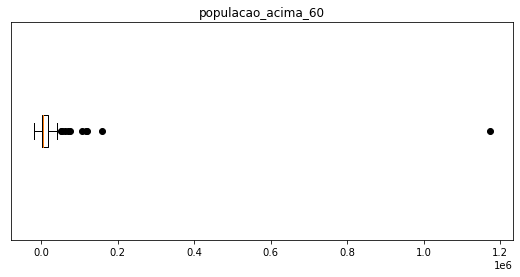

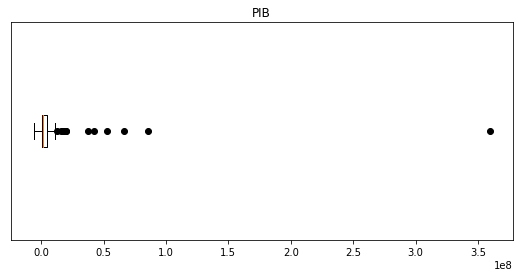

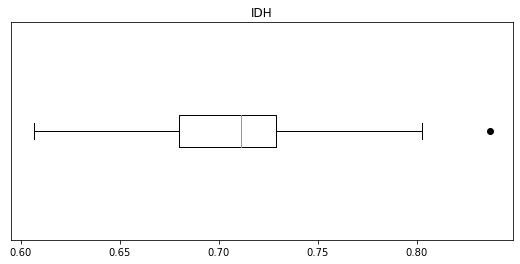

In [36]:
from pyspark.sql.types import FloatType, DoubleType, IntegerType
from pyspark.sql.functions import col, expr
from matplotlib import pyplot as plt
import numpy as np

def gerar_boxplot_pyspark(dataframe):
    # Identificar as colunas numéricas
    colunas_numericas = [f.name for f in dataframe.schema.fields if isinstance(f.dataType, (DoubleType, FloatType, IntegerType))]

    for coluna in colunas_numericas:
        # Calcular os quartis
        quartis = dataframe.stat.approxQuantile(coluna, [0.25, 0.5, 0.75], 0.05)
        Q1, mediana, Q3 = quartis
        IQR = Q3 - Q1

        # Calcular os outliers
        outliers_inferiores = dataframe.filter(col(coluna) < (Q1 - 1.5 * IQR)).select(coluna).rdd.flatMap(lambda x: x).collect()
        outliers_superiores = dataframe.filter(col(coluna) > (Q3 + 1.5 * IQR)).select(coluna).rdd.flatMap(lambda x: x).collect()

        # Preparar dados para plotagem
        dados_plot = [Q1, mediana, Q3, Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]

        # Plotar o BoxPlot
        plt.figure(figsize=(9, 4))
        plt.boxplot([dados_plot], vert=False, positions=[1])
        plt.yticks([]) 
        plt.scatter(outliers_inferiores, [1] * len(outliers_inferiores), color='black')
        plt.scatter(outliers_superiores, [1] * len(outliers_superiores), color='black')
        plt.title(f'{coluna}')
        plt.show()

gerar_boxplot_pyspark(base)

## 6.2 Outlier <a name="6.2"></a>

- O município do Rio de Janeiro possui população idosa:
    - ~7,5 maior que o segundo colocado, São Gonçalo
    - ~4,2 maior que o segundo colocado, Maricá

#### Ordenando municípios pela população idosa

In [37]:
base.orderBy(base.populacao_acima_60.desc()).show()

+---------+--------------------+------------------+---------+-----+
|indicador|           municipio|populacao_acima_60|      PIB|  IDH|
+---------+--------------------+------------------+---------+-----+
|  3304557|      Rio de Janeiro|           1173659|359634753|0.799|
|  3304904|         São Gonçalo|            158253| 20324883|0.739|
|  3301702|     Duque de Caxias|            118914| 53136666|0.711|
|  3303500|         Nova Iguaçu|            117611| 17794593|0.713|
|  3303302|             Niterói|            107530| 66345730|0.837|
|  3301009|Campos dos Goytac...|             76312| 37179860|0.716|
|  3305109|  São João de Meriti|             69370|  8963782|0.719|
|  3300456|        Belford Roxo|             63975|  8839808|0.684|
|  3303906|          Petrópolis|             55676| 15665448|0.745|
|  3306305|       Volta Redonda|             51533| 19671281|0.771|
|  3303401|       Nova Friburgo|             37713|  6324935|0.745|
|  3300704|           Cabo Frio|             376

#### Comparação da população do Rio de Janeiro com São Gonçalo

In [38]:
1173659/158253

7.4163459776433935

#### Ordenando municípios pelo PIB

In [39]:
base.orderBy(base.PIB.desc()).show()

+---------+--------------------+------------------+---------+-----+
|indicador|           municipio|populacao_acima_60|      PIB|  IDH|
+---------+--------------------+------------------+---------+-----+
|  3304557|      Rio de Janeiro|           1173659|359634753|0.799|
|  3302700|              Maricá|             35138| 85814296|0.765|
|  3303302|             Niterói|            107530| 66345730|0.837|
|  3301702|     Duque de Caxias|            118914| 53136666|0.711|
|  3305505|           Saquarema|             18276| 42178208|0.709|
|  3301009|Campos dos Goytac...|             76312| 37179860|0.716|
|  3304904|         São Gonçalo|            158253| 20324883|0.739|
|  3306305|       Volta Redonda|             51533| 19671281|0.771|
|  3303500|         Nova Iguaçu|            117611| 17794593|0.713|
|  3302403|               Macaé|             29842| 17747016|0.764|
|  3303906|          Petrópolis|             55676| 15665448|0.745|
|  3300704|           Cabo Frio|             376

#### Comparação da população do Rio de Janeiro com Maricá

In [40]:
359634753/85814296

4.190848958313426

#### Ordenando municípios pelo IDH

In [41]:
base.orderBy(base.IDH.desc()).show()

+---------+--------------+------------------+---------+-----+
|indicador|     municipio|populacao_acima_60|      PIB|  IDH|
+---------+--------------+------------------+---------+-----+
|  3303302|       Niterói|            107530| 66345730|0.837|
|  3304557|Rio de Janeiro|           1173659|359634753|0.799|
|  3304524|Rio das Ostras|             21650|  8949070|0.773|
|  3306305| Volta Redonda|             51533| 19671281|0.771|
|  3304201|       Resende|             20627| 10754410|0.768|
|  3302700|        Maricá|             35138| 85814296|0.765|
|  3302403|         Macaé|             29842| 17747016|0.764|
|  3301876| Iguaba Grande|              6237|   631409|0.761|
|  3302601|   Mangaratiba|              7519|  3211900|0.753|
|  3303203|     Nilópolis|             27386|  3059486|0.753|
|  3302908|Miguel Pereira|              6157|   632510|0.745|
|  3303401| Nova Friburgo|             37713|  6324935|0.745|
|  3303906|    Petrópolis|             55676| 15665448|0.745|
|  33049

## 6.3 Engenharia de Features <a name="6.3"></a>

Apesar de conseguir extrair mais algumas variáveis extras, me atentei a diminuir o escopo do projeto para conseguir criar todos os entregáveis dentro do prazo, abaixo estão algumas features sugeridas para uma análise mais aprofundada:

- **Renda per capita** acima de 5 salários mínimos (ou mais, dependendo do público-alvo da empresa) para o público mais jovem.
    - Tendo em vista que em alguns casos, é a família que ajuda financeiramente o idoso.
- **Sexo**
    - Caso o empresário descubra que o público-alvo seja majoritariamente masculino ou feminino, pode ajudar na análise do mercado em municípios que possuem mais idosos com esse sexo.
- **Explorar os bairros do Rio de Janeiro**
    - Dado que ele é um outlier e tem maior destaque na análise, pode ajudar em decidir onde seria o melhor lugar para o lar de idosos.
- **Anos anteriores**
    - Analisar anos anteriores das variáveis permitiria entender as suas tendências.
- **Percentual de idosos**
    - A porcentagem de idosos que cada município possui em relação a todo o estado do RJ.
   

## 6.4 Distribuição dos dados <a name="6.4"></a>

- **População idosa**:
    - A distribuição é fortemente inclinada para a direita, indicando que a maioria dos municípios tem uma população idosa relativamente pequena, enquanto poucos municípios têm uma população idosa muito grande.
- **PIB**:
    - Assim como a população idosa, a distribuição do PIB é fortemente inclinada para a direita. Isso sugere que a maioria dos municípios tem um PIB menor, com poucos municípios apresentando valores muito altos de PIB.
- **Índice de Desenvolvimento Humano (IDH)**:
    - A distribuição do IDH sugere seguir uma distribuição normal. A maioria dos municípios tem um IDH ~0,72.

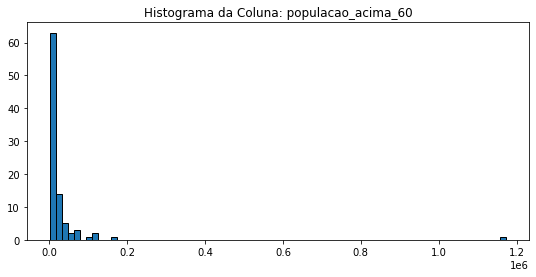

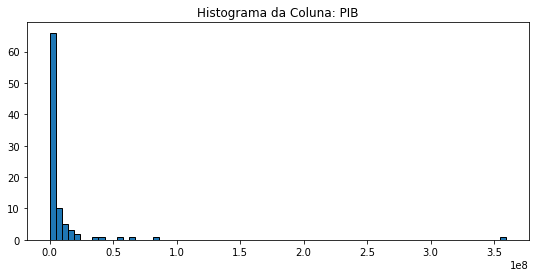

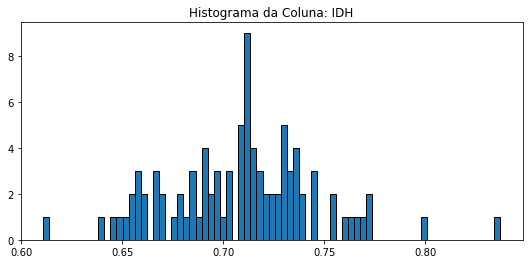

In [42]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, FloatType, IntegerType
from matplotlib import pyplot as plt

def gerar_histograma_pyspark(dataframe):
    # Identificar as colunas numéricas
    colunas_numericas = [f.name for f in dataframe.schema.fields if isinstance(f.dataType, (DoubleType, FloatType, IntegerType))]

    for coluna in colunas_numericas:
        # Coletar os dados da coluna
        dados_coluna = dataframe.select(coluna).rdd.flatMap(lambda x: x).collect()

        # Plotar o Histograma
        plt.figure(figsize=(9, 4))
        plt.hist(dados_coluna, bins=75, edgecolor='black')
        plt.title(f'Histograma da Coluna: {coluna}')
        plt.show()


gerar_histograma_pyspark(base)

## 6.5 Análise das relações entre variáveis e correlação Spearman <a name="6.5"></a>

- Uma das premissas para aplicar correlação é analisar as distribuições dos dados, caso possuam uma distribuição normal com relações lineares, se usa Pearson.
    - Como os dados não se enquadram nesse critério, Spearman foi utilizado, pois ele é mais apropriado para dados não normalmente distribuídos e para capturar relações não lineares.
    
    
- **População idosa e PIB**:
   - Correlação: 0,89 (Relação positiva muito forte).
       - Há uma tendência ascendente no gráfico, indicando que municípios com maiores populações acima de 60 anos tendem a ter um PIB mais alto. 
       - Isso pode sugerir que municípios maiores, tanto em termos de população total, quanto de população idosa, tende a aumentar a economia na região.
- **População Idosa e IDH**:
    - Correlação: 0,60 (Relação positiva moderada).
        - Há uma tendência moderada de aumento do IDH com o aumento da população acima de 60 anos. 
        - Isso pode indicar que municípios com uma proporção maior de idosos tendem a ter um IDH mais elevado, possivelmente refletindo melhores serviços de saúde, maior bem-estar social ou outras características que beneficiam a população idosa.
- **PIB e IDH**:
    - Correlação: 0,58 (Relação positiva moderada).
        - Isso pode indicar que um PIB mais elevado geralmente acompanha um IDH mais alto, ou o inverso.

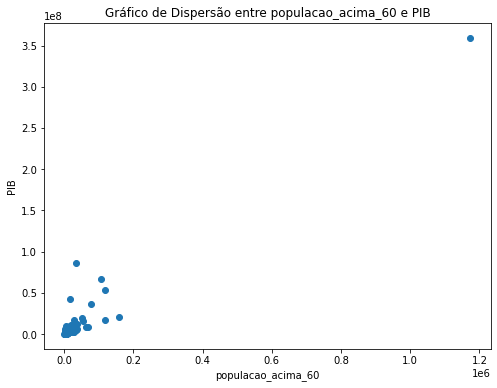

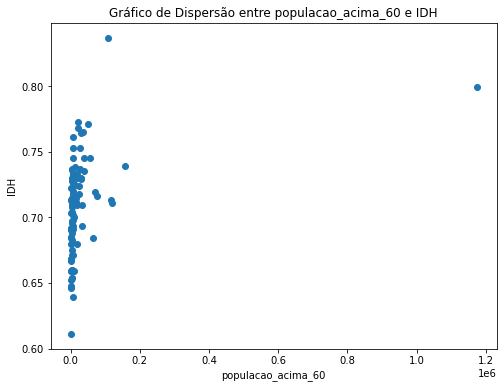

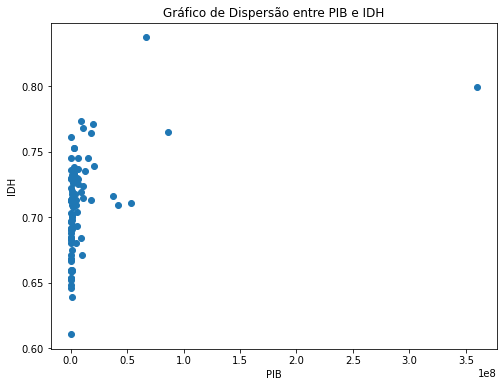

In [43]:
import matplotlib.pyplot as plt
import itertools

def plotar_grafico_dispersao(dataframe):
    # Selecionar apenas as colunas numéricas
    colunas_numericas = [campo.name for campo in dataframe.schema.fields if isinstance(campo.dataType, (FloatType, DoubleType, IntegerType))]
    dataframe_numeric = dataframe.select(*colunas_numericas)
    
    # Gerar todas as combinações únicas de duas variáveis
    combinacoes = list(itertools.combinations(colunas_numericas, 2))
    
    # Plotar as combinações
    for coluna1, coluna2 in combinacoes:
        plt.figure(figsize=(8, 6))
        plt.scatter(dataframe_numeric.select(coluna1).rdd.flatMap(lambda x: x).collect(),
                    dataframe_numeric.select(coluna2).rdd.flatMap(lambda x: x).collect())
        plt.xlabel(coluna1)
        plt.ylabel(coluna2)
        plt.title(f"Gráfico de Dispersão entre {coluna1} e {coluna2}")
        plt.show()

plotar_grafico_dispersao(base)


In [44]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, FloatType, IntegerType
from scipy.stats import shapiro

def testar_normalidade_pyspark(dataframe):
    # Identificar as colunas numéricas
    colunas_numericas = [f.name for f in dataframe.schema.fields if isinstance(f.dataType, (DoubleType, FloatType, IntegerType))]

    for coluna in colunas_numericas:
        # Coletar os dados da coluna
        dados_coluna = dataframe.select(coluna).rdd.flatMap(lambda x: x).collect()

        # Realizar o teste de Shapiro-Wilk
        estatistica, p_valor = shapiro(dados_coluna)

        # Verificar a normalidade
        if p_valor > 0.05:
            print(f'{coluna}: Segue uma distribuição normal. (p-valor = {p_valor})')
        else:
            print(f'{coluna}: Não segue uma distribuição normal. (p-valor = {p_valor})')

testar_normalidade_pyspark(base)

populacao_acima_60: Não segue uma distribuição normal. (p-valor = 3.713263852951692e-20)
PIB: Não segue uma distribuição normal. (p-valor = 1.113416123769346e-19)
IDH: Segue uma distribuição normal. (p-valor = 0.2462666779756546)


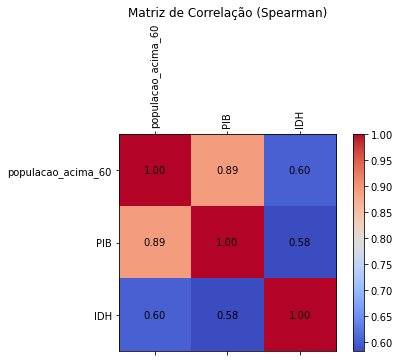

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
from scipy.stats import spearmanr

def calcular_correlacao(dataframe, metodo):
    colunas_numericas = [campo.name for campo in dataframe.schema.fields if isinstance(campo.dataType, (FloatType, DoubleType, IntegerType))]
    dataframe_com_caracteristicas = VectorAssembler(inputCols=colunas_numericas, outputCol="caracteristicas").transform(dataframe.select(*colunas_numericas))
    
    if metodo == "pearson":
        matriz_correlacao = Correlation.corr(dataframe_com_caracteristicas, "caracteristicas").collect()[0]["pearson(caracteristicas)"].toArray()
    elif metodo == "spearman":
        matriz_correlacao = np.zeros((len(colunas_numericas), len(colunas_numericas)))
        for i, coluna1 in enumerate(colunas_numericas):
            for j, coluna2 in enumerate(colunas_numericas):
                dados_coluna1 = dataframe.select(col(coluna1)).rdd.flatMap(lambda x: x).collect()
                dados_coluna2 = dataframe.select(col(coluna2)).rdd.flatMap(lambda x: x).collect()
                coeficiente_spearman, _ = spearmanr(dados_coluna1, dados_coluna2)
                matriz_correlacao[i][j] = coeficiente_spearman

    return matriz_correlacao

def plotar_correlacao(dataframe, metodo="pearson"):
    matriz_correlacao = calcular_correlacao(dataframe, metodo)
    fig, ax = plt.subplots()
    cax = ax.matshow(matriz_correlacao, cmap='coolwarm')
    plt.title(f"Matriz de Correlação ({metodo.capitalize()})")

    for i in range(matriz_correlacao.shape[0]):
        for j in range(matriz_correlacao.shape[1]):
            plt.text(j, i, f"{matriz_correlacao[i][j]:.2f}", va='center', ha='center', color='black')

    nomes_colunas = [campo.name for campo in dataframe.schema.fields if isinstance(campo.dataType, (FloatType, DoubleType, IntegerType))]
    plt.xticks(np.arange(len(nomes_colunas)), nomes_colunas, rotation=90)
    plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
    fig.colorbar(cax)
    plt.show()

plotar_correlacao(base, metodo="spearman")


#### Finaliza a sessão do PySpark

In [46]:
spark.stop()